# Scope of Notebook

The goal of this notebook is to use the propensity data that is now part of our profiles to create some segments for targeting high-value users, and to activate this audience to a 3rd party ad platform.

![EndToEndDesign](images/CMLE-Notebooks-Week5-Workflow-Watsonx.png)

We'll go through several steps:

    - Determining an appropriate propensity interval by analyzing the scoring output.
    - Creating a segment based on the propensity scores.
    - Activating that segment into a destination.


# Setup

This notebook requires some configuration data to properly authenticate to your Adobe Experience Platform instance. You should be able to find all the values required above by following the Setup section of the __README__.

The next cell will be looking for your configuration file to fetch the values used throughout this notebook. See more details in the Setup section of the __README__ to understand how to create your configuration file.
(NOTE: ensure the cluster type for this notebook is set to (Python 3.10 with Spark))

In [0]:
from project_lib import Project
from configparser import ConfigParser
import io

project = Project.access()
config_file = project.get_file('config.ini')

config = ConfigParser()
config.read_string(config_file.read().decode('utf-8'))

client_id = config.get("Authentication", "client_id")
client_secret = config.get("Authentication", "client_secret")
scopes = config.get("Authentication", "scopes")
ims_org_id = config.get("Platform", "ims_org_id")
sandbox_name = config.get("Platform", "sandbox_name")
environment = config.get("Platform", "environment")
dataset_id = config.get("Platform", "dataset_id")
featurized_dataset_id = config.get("Platform", "featurized_dataset_id")
scoring_dataset_id = config.get("Platform", "scoring_dataset_id")

export_path = config.get("Cloud", "export_path")
import_path = config.get("Cloud", "import_path")
data_format = config.get("Cloud", "data_format")
compression_type = config.get("Cloud", "compression_type")
model_name = config.get("Cloud", "model_name")

watson_username = config.get("Watsonx", "watson_username")
watson_apikey = config.get("Watsonx", "watson_apikey")
model_id = config.get("Watsonx", "model_id")

Some utility functions that will be used throughout this notebook:

In [0]:
def get_ui_link(tenant_id, resource_type, resource_id):
    if environment == "prod":
        prefix = f"https://experience.adobe.com"
    else:
        prefix = f"https://experience-{environment}.adobe.com"
    return f"{prefix}/#/@{tenant_id}/sname:{sandbox_name}/platform/{resource_type}/{resource_id}"

To ensure uniqueness of resources created as part of this notebook, we are using your system provisioned username to include in each of the resource titles to avoid conflicts, it is **recommended** to supply a more readable one so you could easily identify resources in AEP created by this notebook

In [0]:
import re

username=watson_username # supply your custom one ex: foo@bar.com
unique_id = s = re.sub("[^0-9a-zA-Z]+", "_", watson_username)

print(f"Username: {username}")
print(f"Unique ID: {unique_id}")

Username: mndymuqvx34peqwqz-ydi68gcdn1kj9ugzqs-towtum
Unique ID: mndymuqvx34peqwqz_ydi68gcdn1kj9ugzqs_towtum


Now lets init the APIClient in order to be able to interact with the platform.

In [0]:
from ibm_watsonx_ai import APIClient

wml_credentials = {
    "instance_id": "openshift",
    "version": "4.8",
    "url": "https://cpd-cpd-instance.apps.p712zf6h.eastus2.aroapp.io",
    "username": watson_username,
    "apikey": watson_apikey
}

project_id = project.get_metadata()['metadata']['guid']
print("Project ID:", project_id)    

client = APIClient(wml_credentials)
client.set.default_project(project_id)



Project ID: 506b7b7a-ecf6-454f-8931-6d1aab37044f


'SUCCESS'

Before we run anything, make sure to install the following required libraries for this notebook. They are all publicly available libraries and the latest version should work fine.

In [0]:
!pip install aepp
!pip install adlfs
!pip install s3fs
!pip install fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.5/169.5 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 629.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 1.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.2/392.2 kB 6.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 4.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 2.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 845.7 kB/s eta 0:00:000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 1.9 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting

We'll be using the [aepp Python library](https://github.com/pitchmuc/aepp) here to interact with AEP APIs and create a schema and dataset suitable for adding our synthetic data further down the line. This library simply provides a programmatic interface around the REST APIs, but all these steps could be completed similarly using the raw APIs directly or even in the UI. For more information on the underlying APIs please see the [API reference guide](https://developer.adobe.com/experience-platform-apis/).

Before any calls can take place, we need to configure the library and setup authentication credentials. For this you'll need the following piece of information. For information about how you can get these, please refer to the Setup section of the Readme:

    - Client ID
    - Client secret

In [0]:
import aepp

aepp.configure(
  environment=environment,
  sandbox=sandbox_name,
  org_id=ims_org_id,
  secret=client_secret,
  scopes=scopes,
  client_id=client_id
)

# 1. Creating a Segment to Target Users based on Propensities

Because the propensity data is already in the Unified Profile, we can now create a segment to target people based on propensities. But it's not immediately obvious what a good value for the upper and lower bound of our target audience should be, so we need to look at the scoring data a bit to understand it better.

## 1.1 Reading the scored data

To that end we need to read the output of the scoring data that we wrote to the Data Landing Zone previously. We use the regular container `dlz-user-container` since this is where we dropped off the data previously.

In [0]:
import fsspec
from aepp import flowservice
from fsspec import AbstractFileSystem

flow_conn = flowservice.FlowService()
dlz_credentials = flow_conn.getLandingZoneCredential()

def getDLZFSPath(credentials: dict):
    if 'dlzProvider' in credentials.keys() and ['Amazon', 's3'] in credentials['dlzProvider']:
        aws_credentials = {
            'key' : credentials['credentials']['awsAccessKeyId'],
            'secret' : credentials['credentials']['awsSecretAccessKey'],
            'token' : credentials['credentials']['awsSessionToken']
        }
        return fsspec.filesystem('s3', **aws_credentials), credentials['dlzPath']['bucketName']
    else:
        abs_credentials = {
            'account_name' : credentials['storageAccountName'],
            'sas_token' : credentials['SASToken']
        }
        return fsspec.filesystem('abfss', **abs_credentials), credentials['containerName']

fs, dlzfs_path = getDLZFSPath(dlz_credentials)
print(dlzfs_path)

dlz-user-container


In [0]:
def get_export_time(fs: AbstractFileSystem, container_name: str, base_path: str, dataset_id: str):
  featurized_data_base_path = f"{container_name}/{base_path}/{dataset_id}"
  featurized_data_export_paths = fs.ls(featurized_data_base_path)
  
  if len(featurized_data_export_paths) == 0:
    raise Exception(f"Found no exports for featurized data from dataset ID {dataset_id} under path {featurized_data_base_path}")
  elif len(featurized_data_export_paths) > 1:
    print(f"Found {len(featurized_data_export_paths)} exports from dataset dataset ID {dataset_id} under path {featurized_data_base_path}, using most recent one")
  
  featurized_data_export_path = featurized_data_export_paths[-1]
  featurized_data_export_time = featurized_data_export_path.strip().split("/")[-1].split("=")[-1]
  return featurized_data_export_time

export_time = get_export_time(fs, dlzfs_path, import_path, scoring_dataset_id)
print(f"Using featurized data export time of {export_time}")


Using featurized data export time of 20240509153003




At that point we're ready to read this data. We're using Spark since it could be pretty large as we're not doing any sampling. Based on the provisioned account Landing Zone could be either configured to use **azure** or **aws**, in case of azure following properties will be used to authenticate using SAS:

    - `fs.azure.account.auth.type.$ACCOUNT.dfs.core.windows.net` should be set to `SAS`.
    - `fs.azure.sas.token.provider.type.$ACCOUNT.dfs.core.windows.net` should be set to `org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider`.
    - `fs.azure.sas.fixed.token.$ACCOUNT.dfs.core.windows.net` should be set to the `SAS token` retrieved earlier.

in case of aws following properties will be used to access data stored in s3:

    - `fs.s3a.access.key` and `spark.hadoop.fs.s3a.access.key` should be the `s3 access key`
    - `fs.s3a.secret.key` and spark.hadoop.fs.s3a.secret.key should be the `s3 secret`
    - `fs.s3a.session.token` and spark.hadoop.fs.s3a.session.token should be set to `s3 session token`
    - `fs.s3a.aws.credentials.provider` and `spark.hadoop.fs.s3a.aws.credentials.provider` should be set to `org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider`
    - `fs.s3.impl` and `spark.hadoop.fs.s3.impl` should be set to `org.apache.hadoop.fs.s3a.S3AFileSystem`

The above properties are calculated based on the landing zone credentials, following util method will set these up. Let's put that in practice and create a Spark dataframe containing the entire featurized data:


In [0]:
def configureSparkSessionAndGetPath(credentials):
    if 'dlzProvider' in credentials.keys() and ['Amazon', 's3'] in credentials['dlzProvider']:
        aws_key = credentials['credentials']['awsAccessKeyId']
        aws_secret = credentials['credentials']['awsSecretAccessKey']
        aws_token = credentials['credentials']['awsSessionToken']
        aws_buket = credentials['dlzPath']['bucketName']
        dlz_folder = credentials['dlzPath']['dlzFolder']
        spark.conf.set("fs.s3a.access.key", aws_key)
        spark.conf.set("fs.s3a.secret.key", aws_secret)
        spark.conf.set("fs.s3a.session.token", aws_token)
        spark.conf.set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
        spark.conf.set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        spark.conf.set("spark.hadoop.fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        spark.conf.set("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
        spark.conf.set("spark.hadoop.fs.s3a.access.key", aws_key)
        spark.conf.set("spark.hadoop.fs.s3a.secret.key", aws_secret)
        spark.conf.set("fs.s3a.session.token", aws_token)
        return f"s3a://${aws_buket}/{dlz_folder}/"
    else:
        dlz_storage_account = credentials['storageAccountName']
        dlz_sas_token = credentials['SASToken']
        dlz_container = credentials['containerName']
        spark.conf.set(f"fs.azure.account.auth.type.{dlz_storage_account}.dfs.core.windows.net", "SAS")
        spark.conf.set(f"fs.azure.sas.token.provider.type.{dlz_storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
        spark.conf.set(f"fs.azure.sas.fixed.token.{dlz_storage_account}.dfs.core.windows.net", dlz_sas_token)
        return f"abfss://{dlz_container}@{dlz_storage_account}.dfs.core.windows.net/"

dlz_path = configureSparkSessionAndGetPath(dlz_credentials)

input_path = f"{dlz_path}{import_path}/{scoring_dataset_id}/exportTime={export_time}/"

df = spark.read.format("csv").option("header", "true").load(input_path)
df.printSchema()



root
 |-- userId: string (nullable = true)
 |-- max_prediction: string (nullable = true)



We can verify it matches what we had written out in fourth weekly assignment:

In [0]:
df.count()

100000


And also do a sanity check on the data to make sure it looks good:


In [0]:
df.show()

+--------------------+--------------+
|              userId|max_prediction|
+--------------------+--------------+
|72725900386185191...|    0.37270755|
|59364352923927343...|   0.026309868|
|87592510713462632...|   0.003964806|
|22026932806196925...|   0.008051798|
|27040490599369997...|   0.020963443|
|21731218032829838...|   0.012924602|
|91178172822455341...|     0.9152621|
|43474115065588286...|    0.32366017|
|38040543354412011...|    0.80780375|
|15902608369025662...|   0.026872324|
|15392325056076882...|    0.86921185|
|44107084534824625...|   0.035695758|
|77448485810623538...|       0.90284|
|47862965208734843...|     0.7465741|
|22038353261823921...|    0.83622617|
|73342859756063641...|  0.0056958226|
|48248380793037744...|    0.03995956|
|87292364327076445...|    0.54598314|
|59469992713770019...|    0.16913667|
|87814673266590141...|    0.01690403|
+--------------------+--------------+
only showing top 20 rows



In [0]:
df = df.fillna(0)

## 1.2 Figuring out the right threshold via a propensity-reach graph

In order to determine a suitable interval of propensities for targeting, we need to understand the distribution of the propensity scores across all our profiles. There's a few different ways we can digest that information, but the very first step is to create a histogram with N bins. Because we may have scored a lot of profiles we do this computation via Spark's histogram_numeric function to make sure it is distributed.


In [0]:
num_buckets = 20
df_histogram = df \
    .selectExpr(f"explode(histogram_numeric(max_prediction, {num_buckets})) as histogram") \
    .selectExpr("round(histogram.x, 2) as propensity_bucket", "histogram.y as reach")
df_histogram.printSchema()
display(df_histogram)

root
 |-- propensity_bucket: double (nullable = true)
 |-- reach: double (nullable = true)



DataFrame[propensity_bucket: double, reach: double]

Now that we have a histogram it should only be a few rows of data, with each row being a bin, so we can just convert it to a `pandas` dataframe to bring it back locally.

In [0]:
df_graph = df_histogram.toPandas()
df_graph.head()

,propensity_bucket,reach
0,0.02,36718.0
1,0.06,4043.0
2,0.13,1589.0
3,0.19,1077.0
4,0.25,1431.0


We can just plot the histogram as-is, and each point will show us how many profiles are in that particular propensity bin.

<Axes: title={'center': 'Number of profiles at a propensity bucket'}, xlabel='propensity_bucket'>

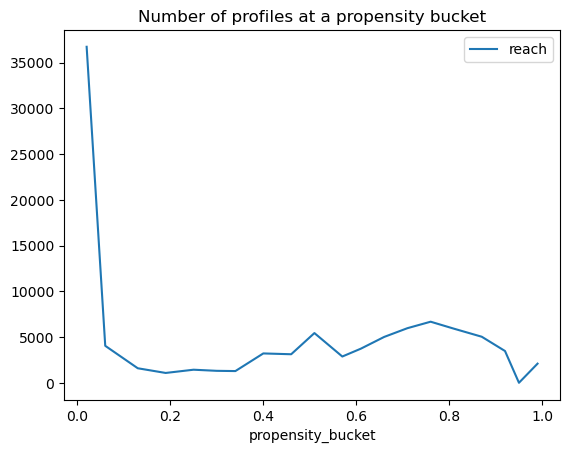

In [0]:
df_graph.plot(
  x="propensity_bucket",
  y="reach",
  title="Number of profiles at a propensity bucket"
)

This is still not quite what we want, because typically we'll want to target profiles who have a propensity either above or below a particular threshold. We can get that by computing the `cumulative` sum using two different methods:

    If we do the cumulative sum from the `smallest bucket to the largest bucket` ("left to right"), then any point in the resulting graph shows us the reach if I was to target all profiles with a propensity below a particular threshold.
    If we do the cumulative sum from the `largest bucket to the smallest bucket` ("right to left"), then any point in the resulting graph shows us the reach if I was to target all profiles with a propensity above a particular threshold.



In [0]:
df_graph["reach_inferior_or_equal"] = df_graph["reach"].cumsum()
df_graph["reach_superior_or_equal"] = df_graph.loc[::-1, "reach"].cumsum()[::-1]
df_graph["reach_inferior"] = df_graph["reach_inferior_or_equal"].shift(1)
df_graph["reach_superior"] = df_graph["reach_superior_or_equal"].shift(-1)
df_graph.head()

,propensity_bucket,reach,reach_inferior_or_equal,reach_superior_or_equal,reach_inferior,reach_superior
0,0.02,36718.0,36718.0,100000.0,NaN,63282.0
1,0.06,4043.0,40761.0,63282.0,36718.0,59239.0
2,0.13,1589.0,42350.0,59239.0,40761.0,57650.0
3,0.19,1077.0,43427.0,57650.0,42350.0,56573.0
4,0.25,1431.0,44858.0,56573.0,43427.0,55142.0


<Axes: title={'center': 'Reach below a propensity'}, xlabel='propensity_bucket'>

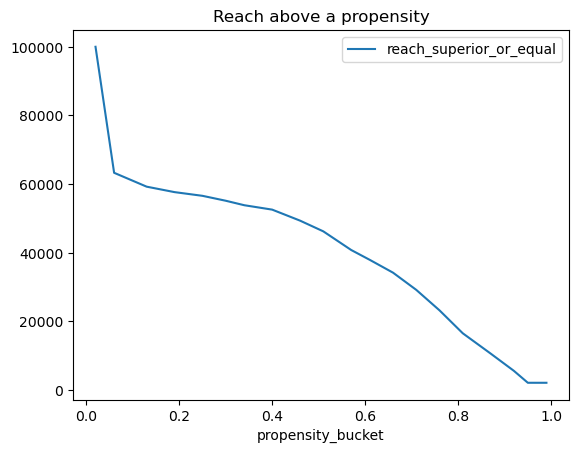

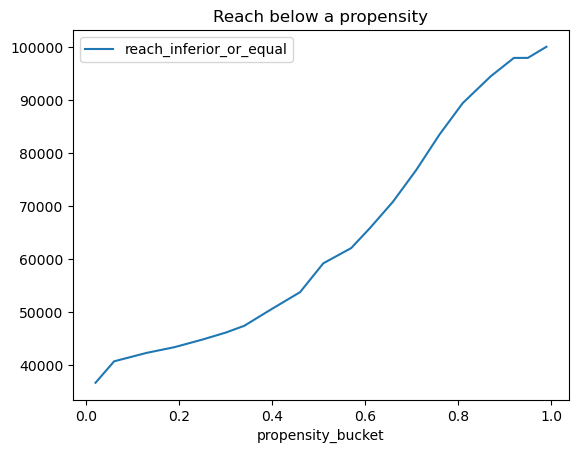

In [0]:
df_graph.plot(
  x="propensity_bucket",
  y="reach_superior_or_equal",
  title="Reach above a propensity"
)
df_graph.plot(
  x="propensity_bucket",
  y="reach_inferior_or_equal",
  title="Reach below a propensity"
)




These graphs are useful to help us define broad propensity-based segments where we only look at profiles with a propensity above or below a threshold, but that's still not enough to help us define a complete interval for our segment.

For that we would ideally like to represent this as a 3-dimensional plot where:

    - On the **X axis** we have the **lower bound** of the interval.
    - On the **Y axis** we have the **upper bound** of the interval.
    - On the **Z axis** you have the **reach** corresponding to that interval.

To get there the first step is to create a function that can tell us the reach given a lower and upper bound:


In [0]:
df_indexed = df_graph.fillna(0).set_index("propensity_bucket")
df_indexed.head()

,reach,reach_inferior_or_equal,reach_superior_or_equal,reach_inferior,reach_superior
propensity_bucket,,,,,
0.02,36718.0,36718.0,100000.0,0.0,63282.0
0.06,4043.0,40761.0,63282.0,36718.0,59239.0
0.13,1589.0,42350.0,59239.0,40761.0,57650.0
0.19,1077.0,43427.0,57650.0,42350.0,56573.0
0.25,1431.0,44858.0,56573.0,43427.0,55142.0


In [0]:
def reach_between(df, propensity_from, propensity_to, total_pop):
  if propensity_from > propensity_to:
    return 0.
  return total_pop - df.loc[propensity_from]["reach_inferior"] - df.loc[propensity_to]["reach_superior"]

total_population = df_graph["reach"].sum()
total_population

100000.0

Now we can create a 2-dimensional array which will represent the reach for each of the bins of the interval. For that we simply iterate over all the bins in both dimensions, and pass it to our reach computation function.

In [0]:
import numpy as np

dim = len(df_indexed)

z = np.zeros((dim, dim))
z.shape

(20, 20)

In [0]:
x = df_graph["propensity_bucket"].values
for index_from, propensity_from in enumerate(x):
  for index_to, propensity_to in enumerate(x):
    reach_x_y = reach_between(df_indexed, propensity_from, propensity_to, total_population)
    z[index_from][index_to] = reach_x_y

Now we can make the 3-dimensional plot as a surface plot to visualize things easily in an interactive plot. We also want to generate the corresponding segment rule on the fly for each point, so for that we need to first get the tenant ID since the propensity XDM field was nested under the tenant ID.

In [0]:
from aepp import schema

schema_conn = schema.Schema()

tenant_id = schema_conn.getTenantId()
tenant_id

'cloudmlecosystem'

In [ ]:
import plotly.graph_objects as go

titlecolor = 'black'
bgcolor = 'white'

layout = go.Layout(
    autosize=False, width=1500, height=800,
    title = 'Propensity-reach Segment Topology',
    showlegend = True,
    scene = dict(
        xaxis_title_text = "Propensity To",
        yaxis_title_text = "Propensity From",
        zaxis_title_text = "Reach",
        aspectmode='manual',
        aspectratio=go.layout.scene.Aspectratio(
            x=1, y=1, z=1)),
    paper_bgcolor = bgcolor,
    plot_bgcolor = bgcolor)

trace = go.Surface(
  x=x, 
  y=x, 
  z=z, 
  hovertemplate=f"""
  Propensity From: %{{y}}<br>
  Propensity To: %{{x}}<br>
  Reach: %{{z}}<br>
  Rule: _{tenant_id}.propensity >= %{{y}} and _{tenant_id}.propensity <= %{{x}}
  """
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

![sklearn_pipeline](images/3d_plot.png)

# 2. Targeting via a Propensity Segment

Now that we know the characteristics of the audience we want to target, the next and final step is to turn this into an actual audience, make sure it is populated, and activate it.


## 2.1 Creating a Propensity Segment

We've identified the upper and lower bound of interest in the previous 3-dimensional plot, so at that point we can copy/paste the corresponding segment rule and plug it into the cell below, so we can use this as the basis for our segment:

In [0]:
segment_rule = f"_{tenant_id}.propensity >= 0.19 and _{tenant_id}.propensity <= 0.92"

In [0]:
from aepp import segmentation

segment_conn = segmentation.Segmentation()

segment_res = segment_conn.createSegment({
  "name": f"[CMLE][Week5] People with a moderate-to-high propensity to subscribe (created by {username})",
  "profileInstanceId": "ups",
  "description": "People who have a moderate-to-high propensity to subscribe",
  "expression": {
      "type": "PQL",
      "format": "pql/text",
      "value": segment_rule
  },
  "schema": {
      "name": "_xdm.context.profile"
  },
  "payloadSchema": "string",
  "ttlInDays": 60
})

segment_id = segment_res["id"]
segment_id

'cc777687-76b2-4f82-aaad-cbff94fcc1c9'

At that point the segment has been created, but it does not mean it will get populated in realtime. If you've clicked in the UI on `Add all segments to schedule` it should be evaluated and populated eventually (up to 24 hours), but if you do not want to wait for that you can trigger a segmentation job on-demand just for this segment:

In [0]:
job_res = segment_conn.createJob([segment_id])
job_id = job_res["id"]
job_id

'b8f11280-2f32-4cfc-adbf-c8f33585a5df'

This can still take a few minutes to run so we just keep checking the status and wait for the segmentation job to complete:

In [0]:
import time

finished = False
while not finished:
  job_info = segment_conn.getJob(job_id)
  job_status = job_info["status"]
  if job_status in ["SUCCEEDED", "FAILED"]:
    total_time = job_info["metrics"]["totalTime"]["totalTimeInMs"] / 1000
    qualified_profiles = job_info["metrics"]["segmentedProfileCounter"][segment_id]
    print(f"Segmentation job completed in {total_time} secs with {qualified_profiles} profiles")
    break
  print(f"Job not yet finished, status is {job_status}")
  time.sleep(60)


Job not yet finished, status is NEW
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is QUEUED
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Job not yet finished, status is PROCESSING
Segmentation job completed in 1339.801 secs with 23709

After the segmentation job is complete for that segment, you should be able to see the population of your segment reflected accurately in the UI at the link below. In our example, based on the propensity interval we selected earlier, we can verify it matches the reach we expected from the 3-dimensional plot:

In [0]:
segment_link = get_ui_link(tenant_id, "segment/browse", segment_id)
print(f"Segment ID {segment_id} available under {segment_link}")

Segment ID cc777687-76b2-4f82-aaad-cbff94fcc1c9 available under https://experience-stage.adobe.com/#/@cloudmlecosystem/sname:cmle-datarobot/platform/segment/browse/cc777687-76b2-4f82-aaad-cbff94fcc1c9


## 2.2 Activating the Segment


Now we're ready to activate the segment and the profiles associated to it to a destination. For that step this is more easily done through the UI, and you can follow [this guide](https://experienceleague.adobe.com/docs/experience-platform/destinations/ui/activate/activate-batch-profile-destinations.html?lang=en) to go through the different steps needed for activation.
You will need to choose a destination for it. You can use any pre-defined destination that you might already have setup, or if you need a dummy destination you can again use the Data Landing Zone to simply use it for validation purposes.